In [187]:
!pip install ppscore
!pip install yellowbrick

In [222]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ppscore as pps
import warnings
warnings.simplefilter("ignore")
pd.set_option('display.max_columns', 500)
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRFRegressor
from yellowbrick.regressor import PredictionError

In [189]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Codenation/enem2/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Codenation/enem2/test.csv')

In [190]:
test_inscricao = test.NU_INSCRICAO

In [191]:
print(train.shape, test.shape)

(13730, 167) (4576, 47)


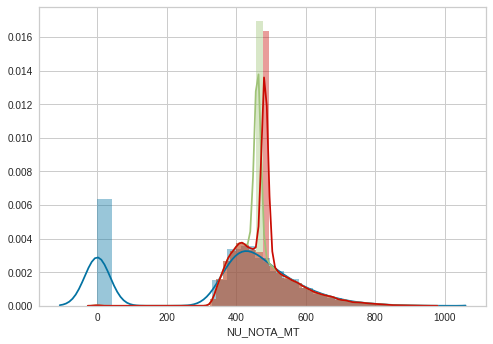

In [192]:
#target analysis
y = train.NU_NOTA_MT
sns.distplot(y.fillna(0))
sns.distplot(y.fillna(y.median()))
sns.distplot(y.fillna(y.mean()))

In [193]:
y = train.NU_NOTA_MT.fillna(0)

In [194]:
#ajust train and test columns
keep_cols = [i for i in train.columns if i in test.columns]
X = train[keep_cols]

In [195]:
#aux DF
aux = pd.DataFrame(index=X.columns, data={'type': X.dtypes, 
                                              'uniques': X.nunique(),
                                              'nulls': X.isnull().sum(),
                                              'nulls perc': X.isnull().sum() / len(train)})
aux[aux['nulls'] != 0].sort_values(by=['nulls'], ascending=False).head(10)

,type,uniques,nulls,nulls perc
TP_ENSINO,float64,3,9448,0.688128
TP_DEPENDENCIA_ADM_ESC,float64,4,9448,0.688128
Q027,object,13,7373,0.536999
NU_NOTA_LC,float64,2774,3597,0.261981
TP_STATUS_REDACAO,float64,9,3597,0.261981
NU_NOTA_COMP1,float64,15,3597,0.261981
NU_NOTA_COMP2,float64,13,3597,0.261981
NU_NOTA_COMP3,float64,12,3597,0.261981
NU_NOTA_COMP4,float64,14,3597,0.261981
NU_NOTA_COMP5,float64,14,3597,0.261981


In [196]:
#separate numeric and categorical vars
cat_vars = aux[aux['type'] == 'object'].index
num_vars = aux[aux['type'] != 'object'].index

In [197]:
#ppscore df
df_predictors = pps.predictors(train, 'NU_NOTA_MT')
df_predictors.head()

,x,ppscore,y,task,metric,baseline_score,model_score
0,Q006,0.072775,NU_NOTA_MT,regression,mean absolute error,77.004660,71.400650
1,NU_NOTA_REDACAO,0.071914,NU_NOTA_MT,regression,mean absolute error,77.004660,71.466924
2,TP_DEPENDENCIA_ADM_ESC,0.069471,NU_NOTA_MT,regression,mean absolute error,75.405139,70.166664
3,NU_NOTA_COMP3,0.059457,NU_NOTA_MT,regression,mean absolute error,77.004660,72.426198
4,NU_NOTA_COMP2,0.057024,NU_NOTA_MT,regression,mean absolute error,77.004660,72.613537


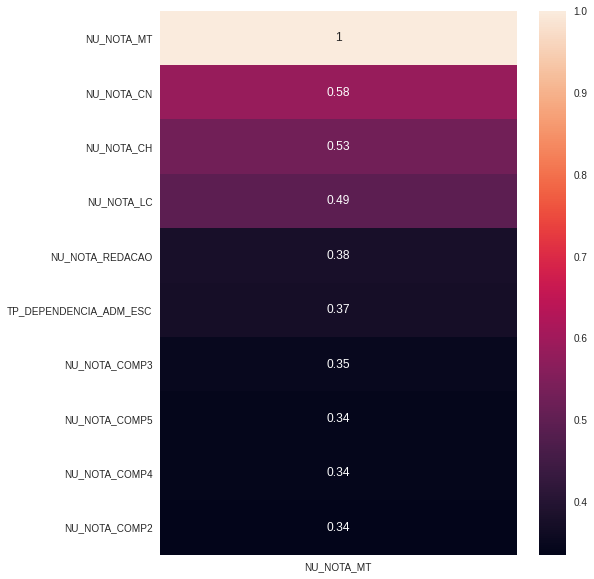

In [198]:
#correlation with target
plt.figure(figsize=(8, 10))
corr = train.corr()
sns.heatmap(corr[['NU_NOTA_MT']].sort_values(by=['NU_NOTA_MT'], ascending=False).head(10), annot=True)

In [199]:
#baseline: 5 most correlate variables
base_vars = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_REDACAO', 'TP_DEPENDENCIA_ADM_ESC']
X[base_vars].head()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,TP_DEPENDENCIA_ADM_ESC
0,436.3,495.4,581.2,520.0,NaN
1,474.5,544.1,599.0,580.0,2.0
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [200]:
#fill missing values
X[base_vars] = train[base_vars].fillna(0)
test[base_vars] = test[base_vars].fillna(0)

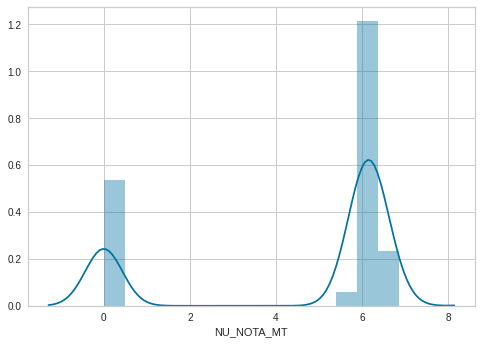

In [201]:
y_log = np.log1p(y)
sns.distplot(y_log)

In [202]:
#normalize vars
'''quant_trans = QuantileTransformer()
X_transformed = quant_trans.fit_transform(X[base_vars])
test_transformed = quant_trans.transform(test[base_vars])
X[base_vars] = X_transformed
test[base_vars] = test_transformed'''

'quant_trans = QuantileTransformer()\nX_transformed = quant_trans.fit_transform(X[base_vars])\ntest_transformed = quant_trans.transform(test[base_vars])\nX[base_vars] = X_transformed\ntest[base_vars] = test_transformed'

In [203]:
def validation_score(model, X, y):
    kfold = KFold(n_splits=10, shuffle=True)
    error = -np.mean(cross_val_score(model, X, y, cv=kfold, scoring='neg_root_mean_squared_error'))
    return error

In [226]:
#defining estimators
linreg = LinearRegression()
lasso = Lasso(alpha=0.8)
knn = KNeighborsRegressor(n_neighbors=4)
rfr = RandomForestRegressor()
xgb = XGBRFRegressor(objective='reg:squarederror')
gradb = GradientBoostingRegressor()

In [227]:
#compare different models
rint('Linear Regression error: ', validation_score(linreg, X[base_vars], y),
      '\nLasso error: ',  validation_score(lasso, X[base_vars], y),
      '\nKNN error: ', validation_score(knn, X[base_vars], y),
      '\nRandom Forest error: ', validation_score(rfr, X[base_vars], y),
      '\nXGBoost error: ', validation_score(xgb, X[base_vars], y),
      '\nGradient Boosting error: ', validation_score(gradb, X[base_vars], y))

Linear Regression error:  71.37225456842839 
Lasso error:  71.41549610503301 
KNN error:  71.02805879791853 
Random Forest error:  66.0921587110629 
XGBoost error:  65.62252598961096 
Gradient Boosting error:  63.66243712142055


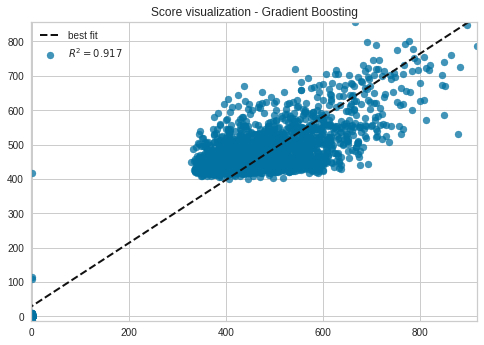

In [228]:
#inference visualization
X_train, X_valid, y_train, y_valid = train_test_split(X[base_vars], y, test_size=0.2)
visualizer = PredictionError(gradb)
visualizer.fit(X_train, y_train)
visualizer.score(X_valid, y_valid)
plt.title('Score visualization - Gradient Boosting')
plt.legend()

In [230]:
test[base_vars]

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_REDACAO,TP_DEPENDENCIA_ADM_ESC
0,464.8,443.5,431.8,420.0,0.0
1,391.1,491.1,548.0,580.0,0.0
2,595.9,622.7,613.6,320.0,2.0
3,0.0,0.0,0.0,0.0,0.0
4,592.9,492.6,571.4,320.0,2.0
...,...,...,...,...,...
4571,398.3,558.2,511.6,500.0,2.0
4572,427.6,579.7,471.1,520.0,2.0
4573,639.2,643.8,604.9,640.0,0.0
4574,427.1,467.9,540.2,520.0,0.0


In [232]:
#fit train and predict test
gradb.fit(X[base_vars], y)
predictions = gradb.predict(test[base_vars])

In [234]:
sub = pd.DataFrame({'NU_INSCRICAO': test_inscricao, 
                    'NU_NOTA_MT': predictions})
sub.to_csv('answer.csv', index=False)